# Omigami Tutorial
Omigami's main class, `FeatureSelector`, implements the minimally biased variable selection algorithm described in _Shi L, Westerhuis JA, Rosén J, Landberg R, Brunius C. Variable selection and validation in multivariate modelling. Bioinformatics. 2019 Mar 15;35(6):972-980. doi: 10.1093/bioinformatics/bty710. PMID: 30165467; PMCID: PMC6419897._ For more details regarding the algorithm, please refer to the original paper. 

In this notebook, a simple application of this tool will be showcased.

### Imports and client setup
We start importing `FeatureSelector` from `omigami`and setting up a Dask cluster to enable parallel computation.
The cluster will run on our local machine and a dashboard that shows the state of the computation will be will be available at http://localhost:8787/status.

In [1]:
from omigami import FeatureSelector
import dask

# Spin up a local cluster using dask 
from dask.distributed import Client
client = Client()

## Load the data
For this tutorial, we'll use the "mosquito" database (_Buck M. et al. (2016) Bacterial associations reveal spatial population dynamics in Anopheles gambiae mosquitoes. Sci. Rep., 6, 22806._). The database represents 29 measurements of operational taxonomic units (OTU) performed on mosquitoes. The target variable ("Yotu") is the village where the mosquitoes have been collected.

In [2]:
import pandas as pd

df = (
    pd.read_csv("../tests/assets/mosquito.csv")
    .rename(columns={"Unnamed: 0": "sample_id"})
    .set_index("sample_id")
    .sample(frac=1)  # to shuffle
)
df.head()

,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,OTU_6670,OTU_6675,OTU_6681,OTU_6685,OTU_6686,OTU_6691,OTU_6693,OTU_6702,OTU_6709,Yotu
sample_id,,,,,,,,,,,,,,,,,,,,,
VK3_47,396,0,14,19,36,0,0,0,0,123,...,0,0,0,0,0,0,0,0,0,VK3
VK3_43,922,0,13,27,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,VK3
VK5_2,578,0,1,0,413,0,96,0,0,0,...,0,0,0,0,0,0,0,0,0,VK5
VK7_28,551,0,23,14,0,0,0,1,0,16,...,0,4,2,0,0,3,3,0,0,VK7
VK3_45,5136,0,29,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,VK3


We have to separate the predictors variables `X` (OTUs) from the target variable `y` ("Yotu").

In [3]:
X = df.drop(columns=["Yotu"]).values
y = df.Yotu.values

## Feature selection
Now we are ready to perform the feature selection. First of all we instantiate the feature selector class. To keep the algorithm runtime short, we'll specify few repetitions, few CV splits and a high feature dropout rate (the fraction of features dropped at every step of the recursive feature elimination). In a real case scenario, a higher number of repetitions and a lower dropout rate would be appropriate.

In [4]:
fs = FeatureSelector(
    n_outer=4,
    n_repetitions=3,
    metric="MISS",
    estimator="RFC",
    features_dropout_rate=0.2,
    random_state=1
)

### Sample correlation
The fit method will assume that every sample is independent from the others. If the samples are correlated, e.g. they belong to the same patients, an additional vector `groups` should be passed to the fit method:
```python
>>> groups
numpy.array([1, 1, 1, 2, 2, ..., 3, 1, 2])
>>> fs.fit(X, y, groups=groups)
```
This vector would represent the group (as integer index) to which each sample belongs.

Now we can call the method `fit`, that would actually compute the selected features. Features will be also available as attributes as `selected_features`.

In [5]:
%%time 
fs.fit(X, y, executor=client)

CPU times: user 1.77 s, sys: 108 ms, total: 1.88 s
Wall time: 58.5 s


## Results
Now we can print the selected features:

In [6]:
feature_names = df.drop(columns=["Yotu"]).columns
selected_features = fs.get_selected_features(feature_names)

In [7]:
selected_features_min_model = selected_features.min_feats
print(selected_features)

SelectedFeatures(min_feats=['OTU_28', 'OTU_4', 'OTU_400', 'OTU_243', 'OTU_3454', 'OTU_114', 'OTU_1208', 'OTU_16', 'OTU_39', 'OTU_134', 'OTU_26', 'OTU_99', 'OTU_2749'], max_feats=['OTU_28', 'OTU_4', 'OTU_3454', 'OTU_39', 'OTU_243', 'OTU_400', 'OTU_16', 'OTU_1208', 'OTU_114', 'OTU_21', 'OTU_337', 'OTU_178', 'OTU_134', 'OTU_91', 'OTU_2749', 'OTU_11', 'OTU_6', 'OTU_1002', 'OTU_99', 'OTU_757', 'OTU_22', 'OTU_180'], mid_feats=['OTU_28', 'OTU_243', 'OTU_4', 'OTU_400', 'OTU_3454', 'OTU_178', 'OTU_337', 'OTU_16', 'OTU_1208', 'OTU_6', 'OTU_91', 'OTU_114', 'OTU_39', 'OTU_21', 'OTU_134', 'OTU_2749', 'OTU_1002'])


## Plots

Omigami offers plots to visualize the results of the feature selection. The plots supported are:
- Validation curve
- Feature ranks

In [8]:
from omigami.plot_utils import plot_validation_curves, plot_feature_rank

### Validation Curves

TODO: talk about it

<AxesSubplot:xlabel='# features', ylabel='Fitness score'>

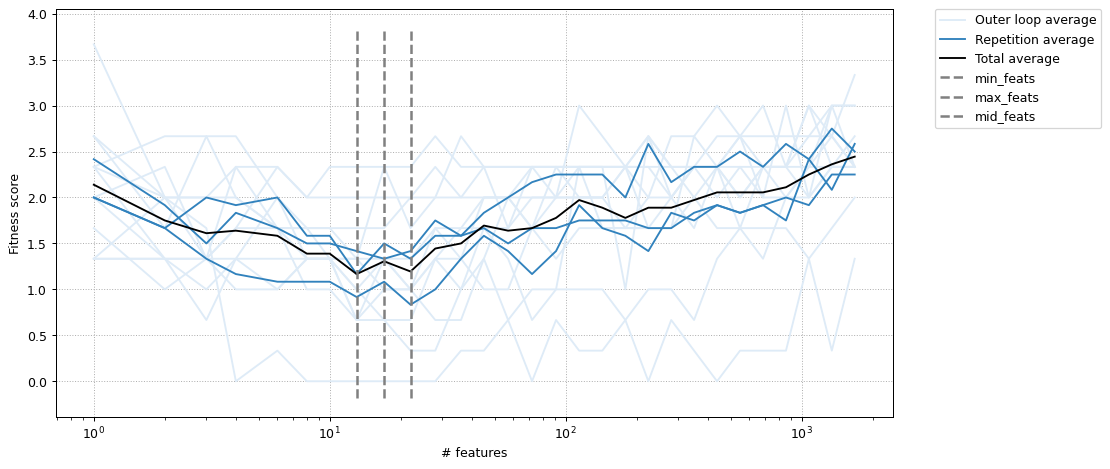

In [17]:
plot_validation_curves(fs, figsize=(12,6), dpi=90)

### Feature Ranks

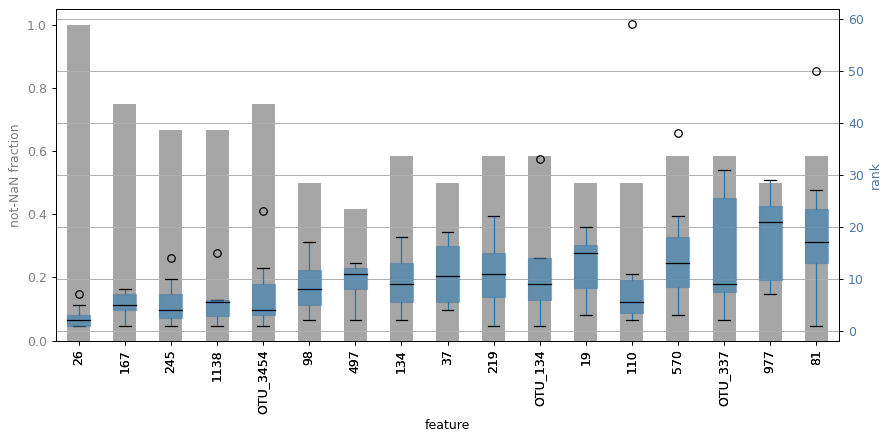

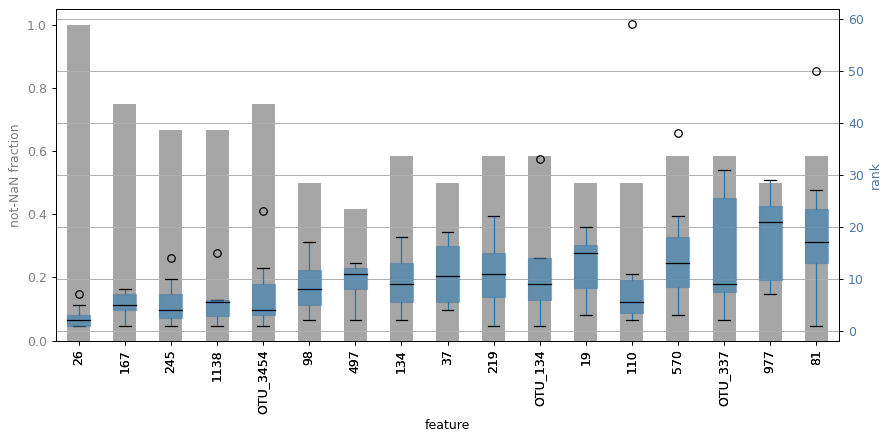

In [18]:
plot_feature_rank(fs, "mid", selected_features.mid_feats, figsize=(10, 5), dpi=90)

## Cleanup
Finally we can close the cluster client

In [19]:
client.close()